In [35]:
#importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from functools import reduce
import requests as rq
from io import BytesIO

In [36]:
#criando variável para leitura de base de dados

url = "https://raw.githubusercontent.com/samuelslucas/desafio_4i/main/dados_desafiodatascientistintern_vendas_distribuidoras_anp.xlsx"
data = rq.get(url).content

In [37]:
#separando diferentes combustíveis em diferentes bases

anp_diesel = pd.read_excel(BytesIO(data),sheet_name="diesel")
anp_gasolina = pd.read_excel(BytesIO(data),sheet_name="gasolina")
anp_etanol = pd.read_excel(BytesIO(data),sheet_name="etanol")

 Qual é a sazonalidade da venda de combustíveis? Essa sazonalidade é igual em todos os estados?

In [38]:
#função que cria um gráfico de consumo de um dado combustível em uma dada região

def combustivel_br(dfcombbr,nome_comb,regiao):
    anp_br = dfcombbr[dfcombbr["regiao"] == regiao] #filtrando por regiao
    combbr, ax = plt.subplots(figsize=(12,4))
    for i in range(10,22):
        ax.plot(anp_br["meses"],anp_br.iloc[:,i],label=anp_br.columns[i]) #loop para facilitar o plot dos anos escolhidos
        ax.set_xlabel("Meses")
        ax.set_ylabel("Metros Cúbicos")
        ax.set_title(f"Consumo de {nome_comb} no {regiao} entre 2008 e 2019")
        combbr.legend()
    return combbr

C:\Users\Windows\AppData\Local\Temp\ipykernel_6680\67587637.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  combbr, ax = plt.subplots(figsize=(12,4))


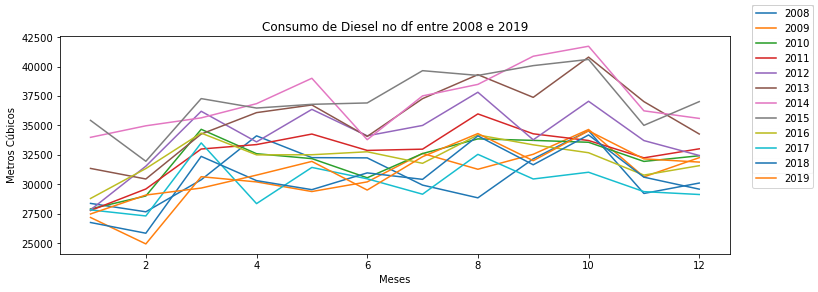

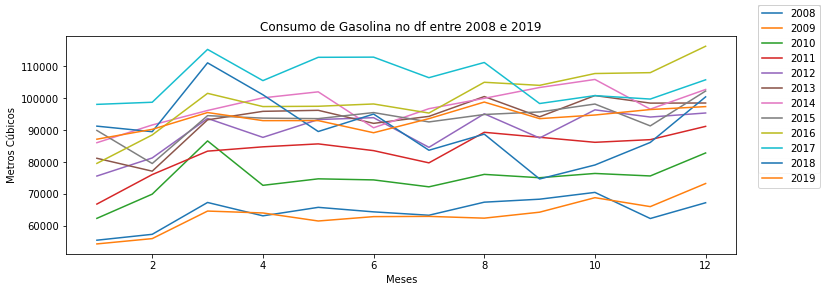

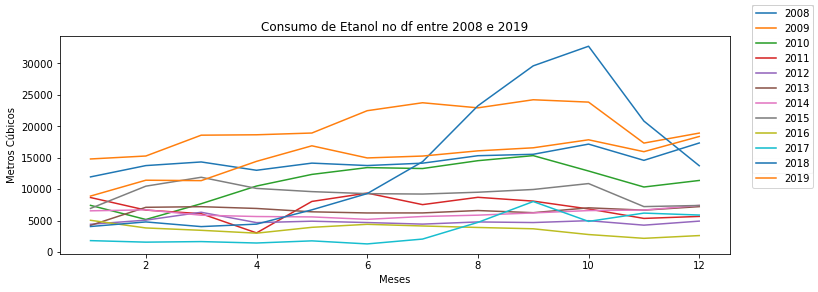

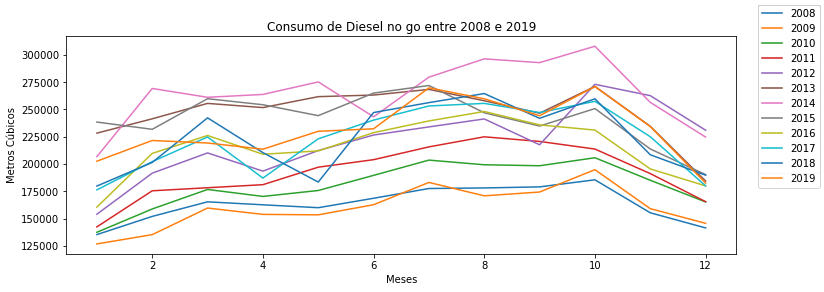

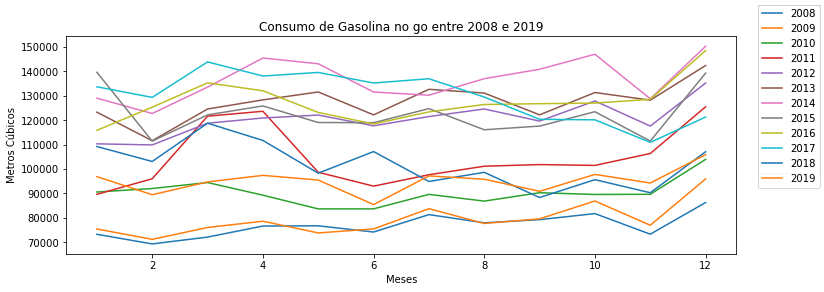

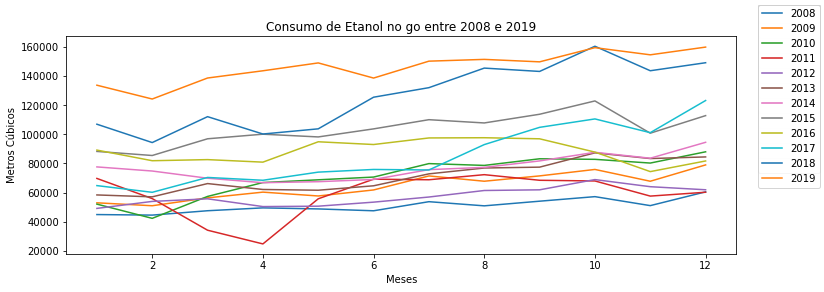

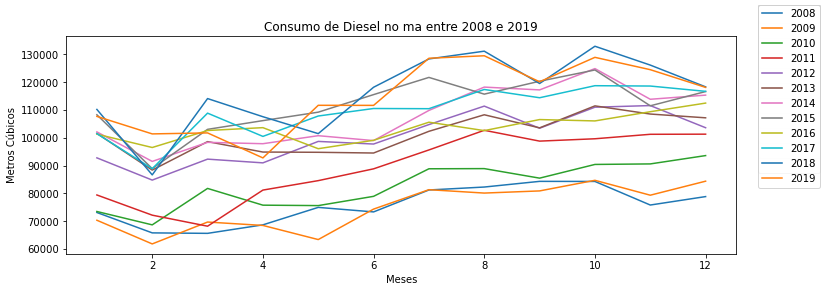

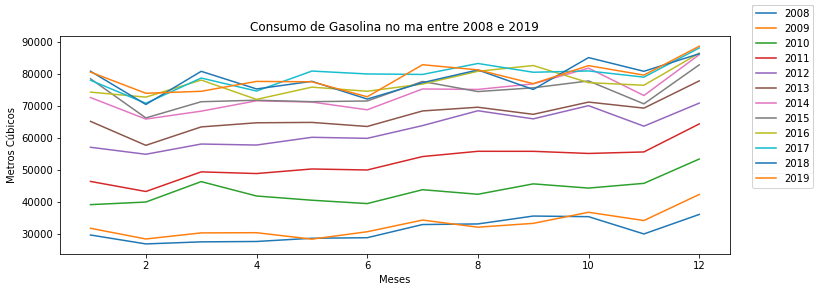

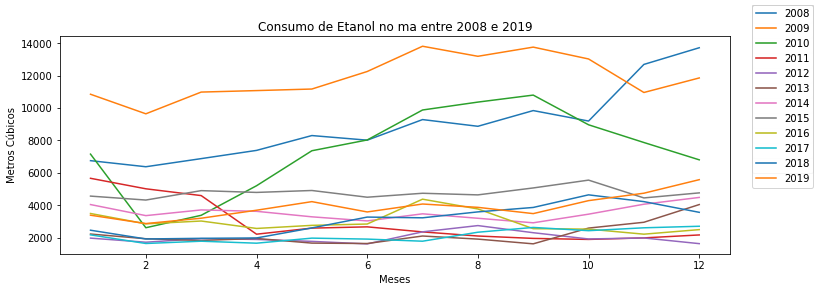

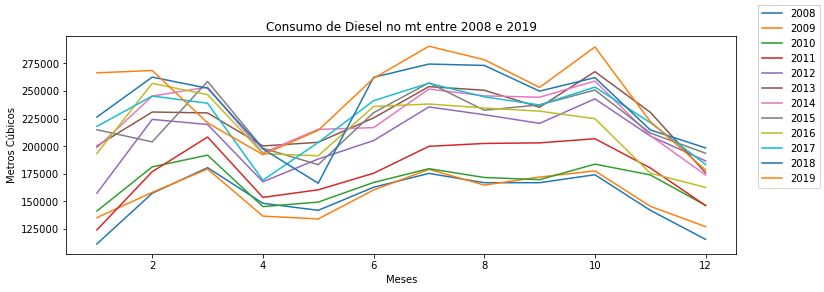

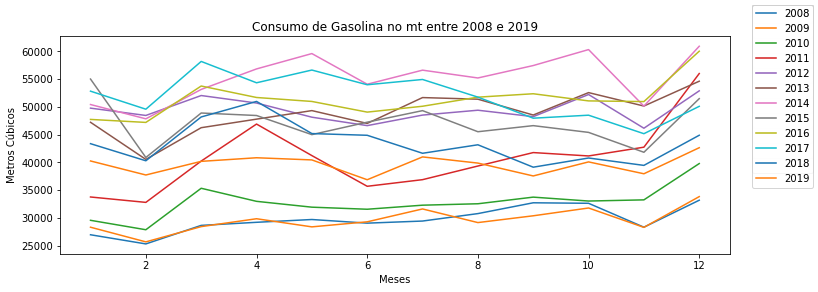

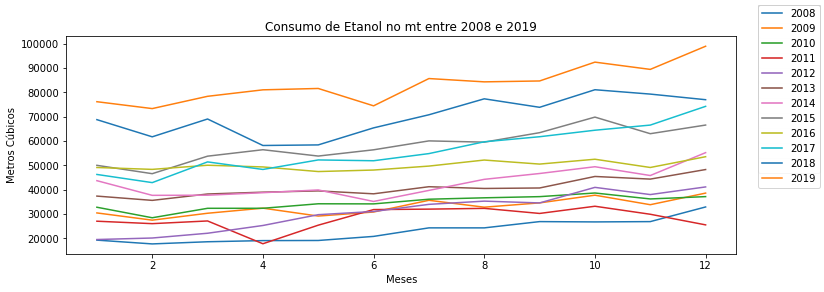

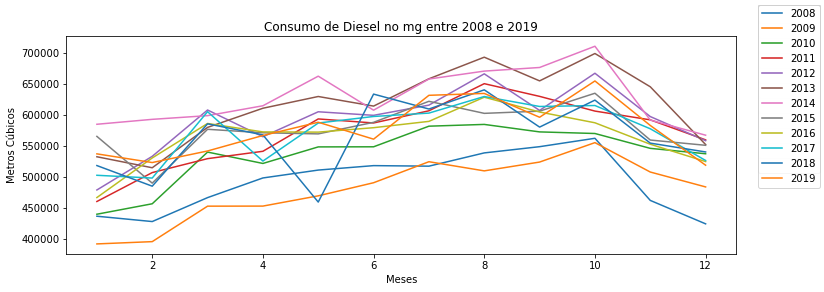

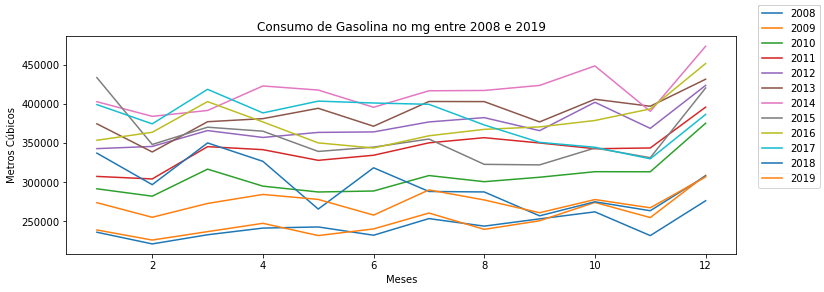

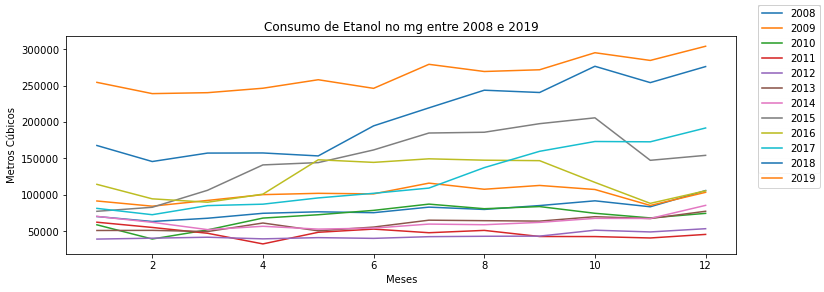

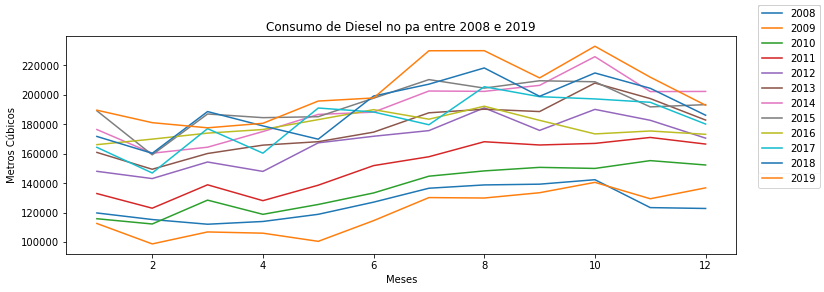

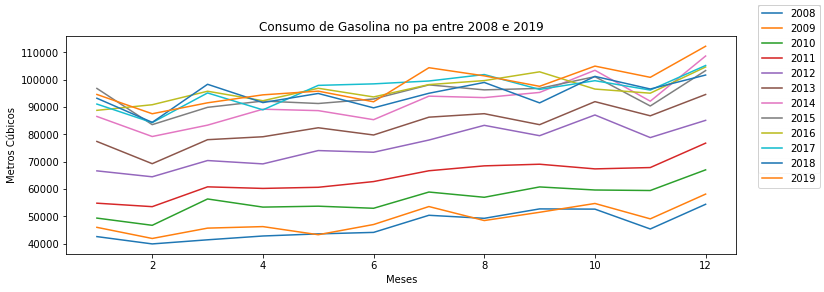

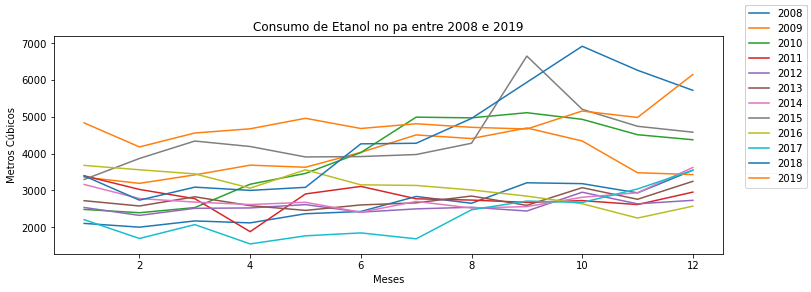

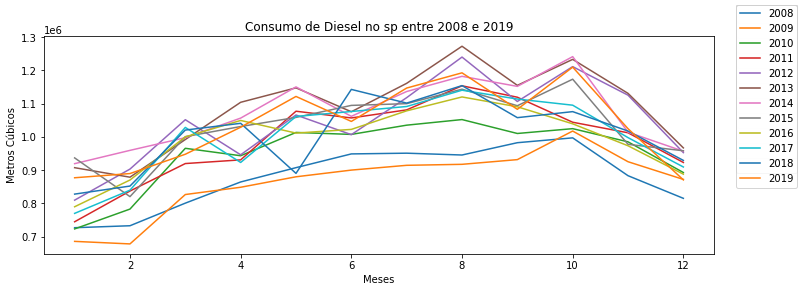

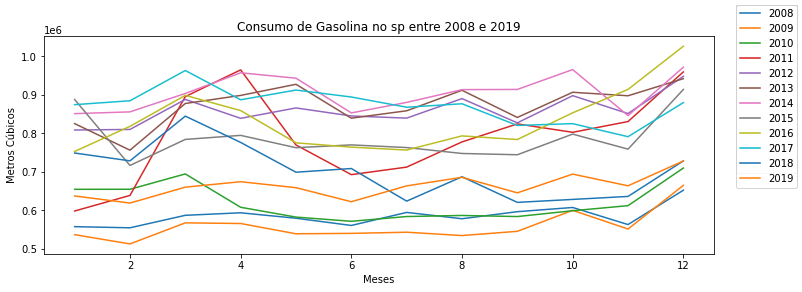

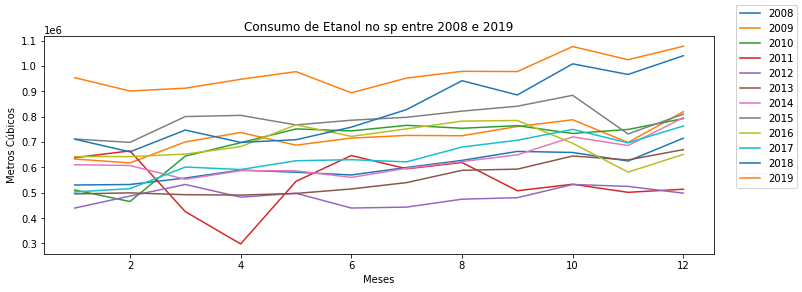

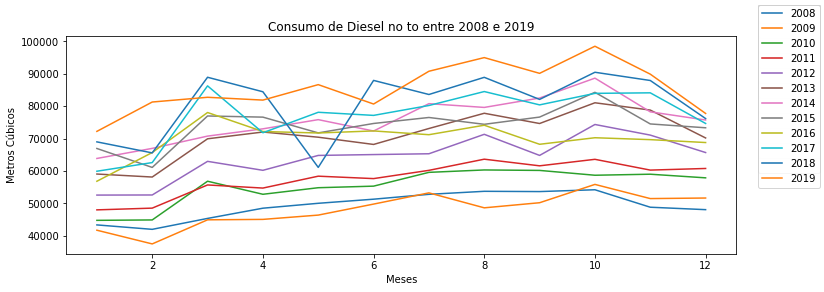

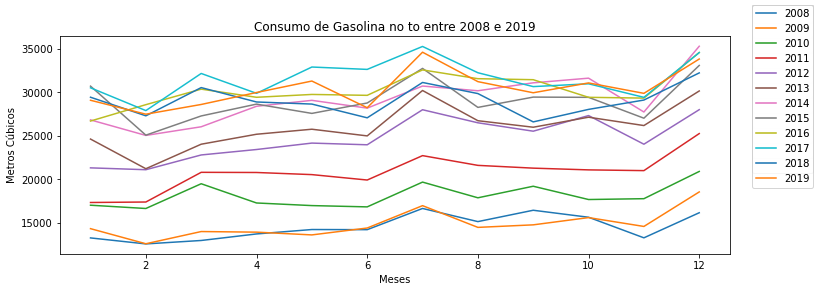

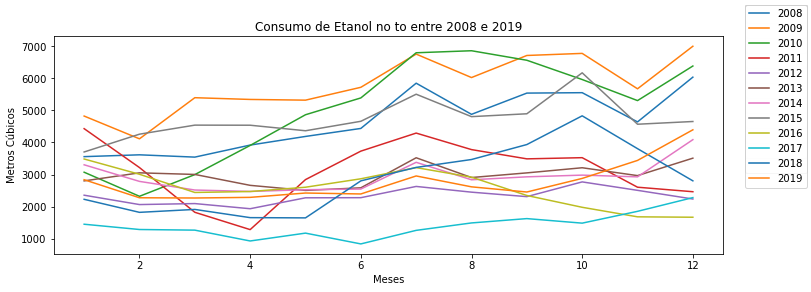

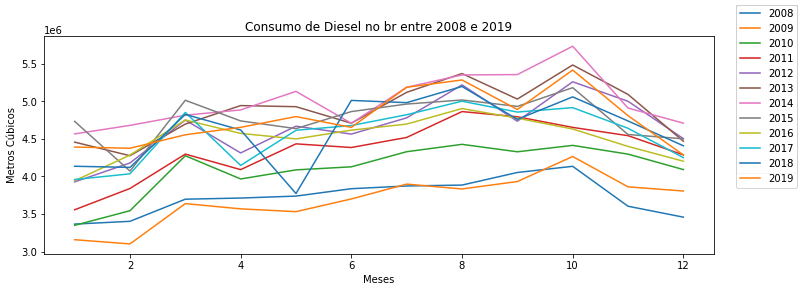

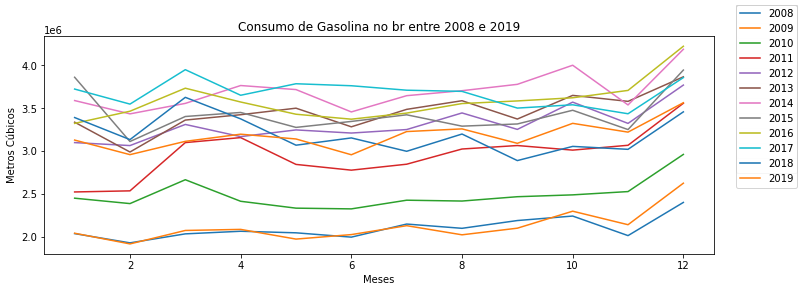

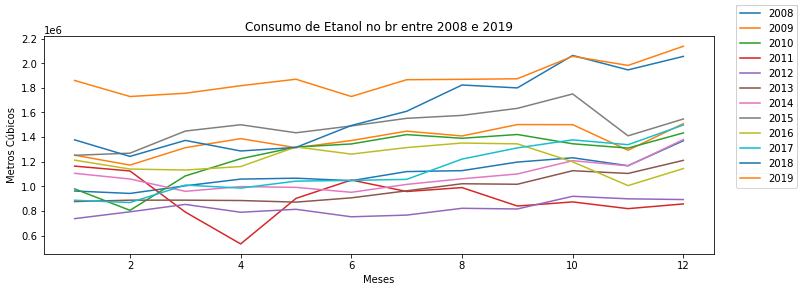

In [39]:
#loop para criar gráfico de consumo dos 3 combustíveis para todos os estados

for ite in anp_diesel["regiao"].unique():
    analisecombs_d = combustivel_br(anp_diesel,"Diesel",ite)
    analisecombs_g = combustivel_br(anp_gasolina,"Gasolina",ite)
    analisecombs_e = combustivel_br(anp_etanol,"Etanol",ite)

A partir dessas visualizações não é possível inferir uma sazonalidade. Apesar de que, para todos os estados existem certas tendências temporais que se repetem ao longo dos anos.

Só será possível inferir se existe sazonalidade a partir da metodologia específica a seguir.

In [40]:
#como o formato da base de dados dificulta a visualização de sazonalidades, altera-se a base paraque ela vire uma série temporal

#função para transformar os meses as linhas e anos das colunas em uma única coluna em datetime
def cnv(row):
    datStr = row.ano + ' ' + str(row.meses)
    return pd.to_datetime(datStr, format='%Y %m').date()

#função para transformar as bases de dados em séries temporais e depois aplicar um modelo que reconhece a sazonalidade
def sazonalidade_vendas(df_comb,nome_comb,regiao):
    df_comb=df_comb[df_comb['regiao']==regiao]
    df_comb = df_comb.drop(['regiao'], axis=1)
    df2 = df_comb.set_index('meses').stack().to_frame(name='vendas_comb')
    df2 = df2.reset_index().rename(columns={'level_1': 'ano'})
    df2['ano'] = df2['ano'].astype(str)
    df2['data'] = df2.apply(cnv, axis=1)
    df2 = df2.drop(['ano', 'meses'], axis=1).sort_index(axis=1)
    df2 = df2.sort_values(by='data')
    df2.index = pd.to_datetime(df2.data, format="%Y-%m-%d")
    df2 = df2.drop(['data'], axis=1)
    resultado = seasonal_decompose(df2) #aplicando componente sazonal na série temporal
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_xlabel("Meses")
    ax.set_ylabel("Milhões de Metros Cúbicos")
    ax.set_title(f"Sazonalidade da venda de {nome_comb} no {regiao}")
    resultado.seasonal.plot()
    plt.tight_layout()

C:\Users\Windows\AppData\Local\Temp\ipykernel_6680\4130102941.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,4))


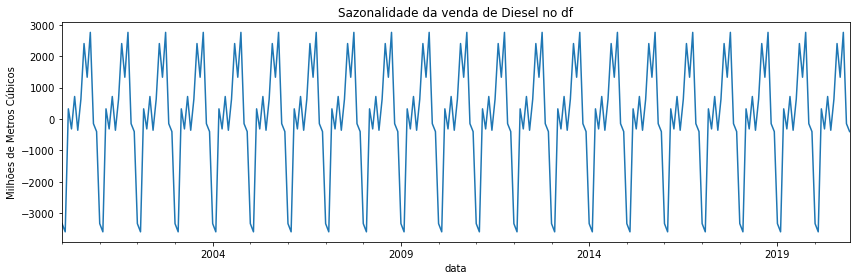

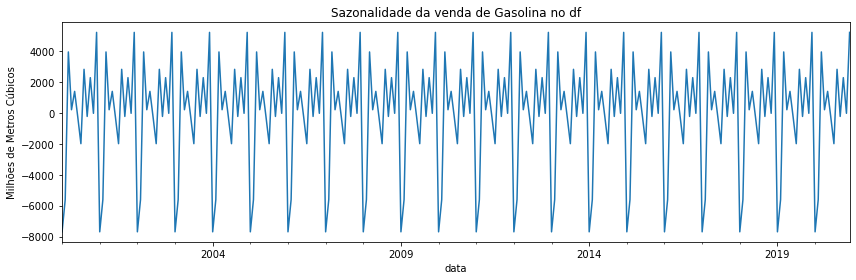

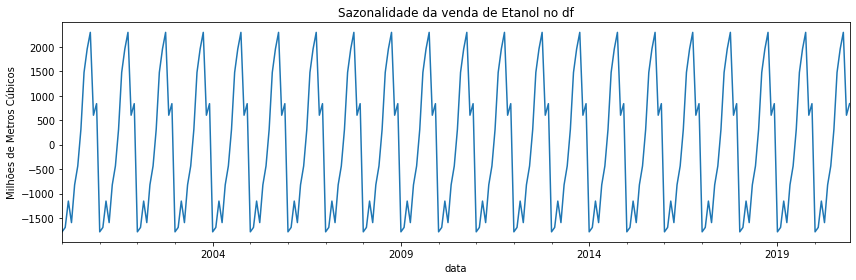

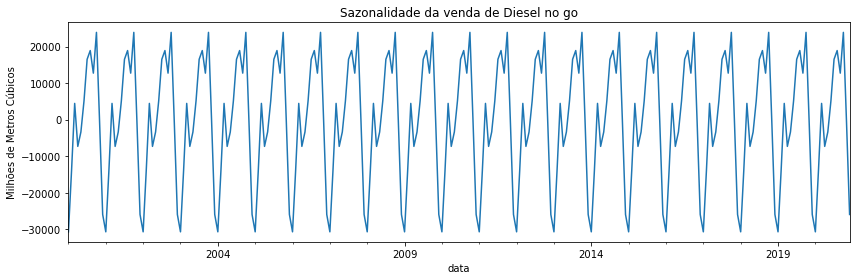

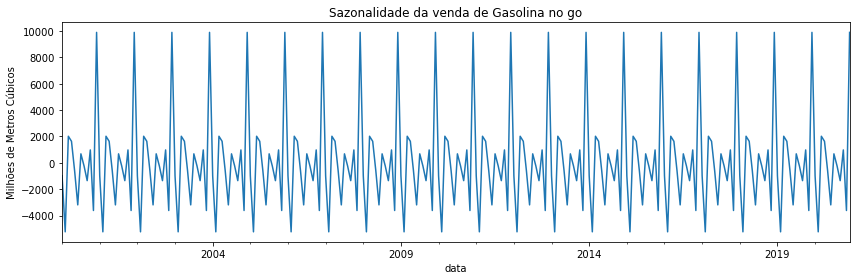

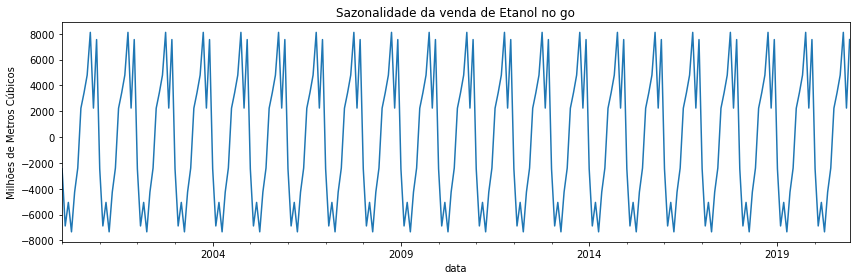

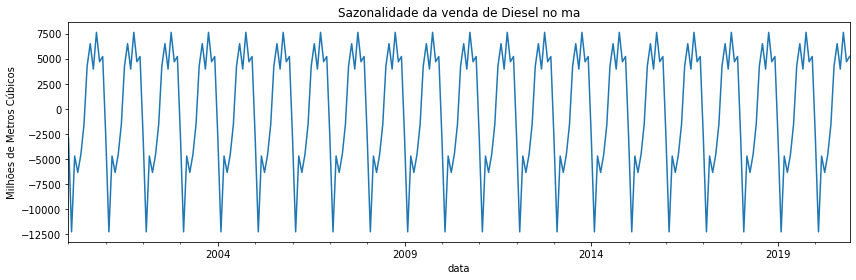

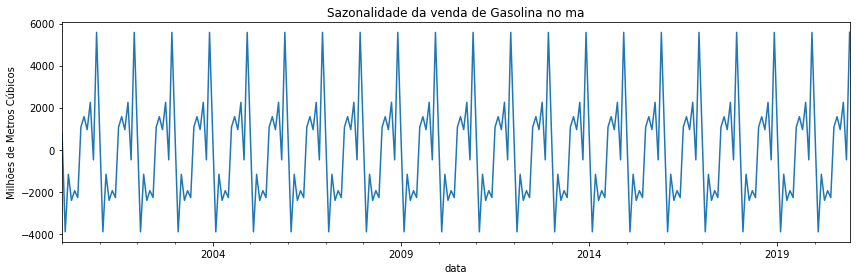

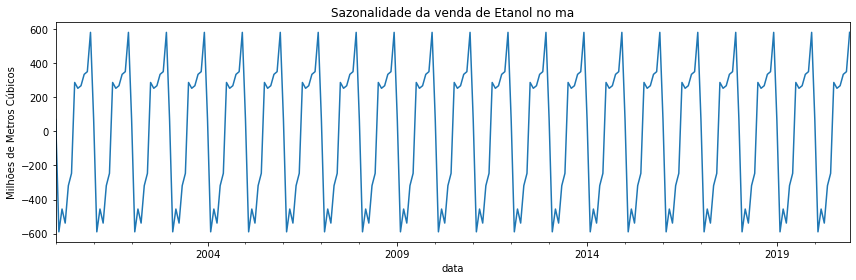

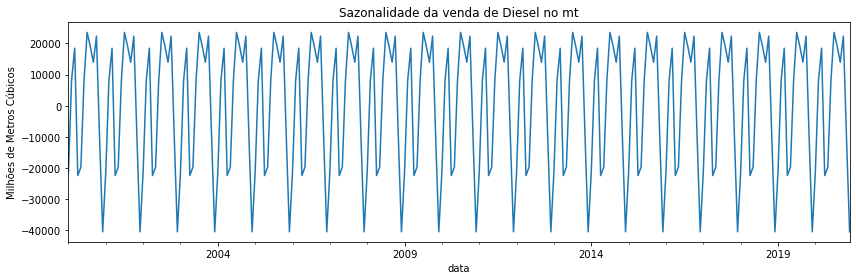

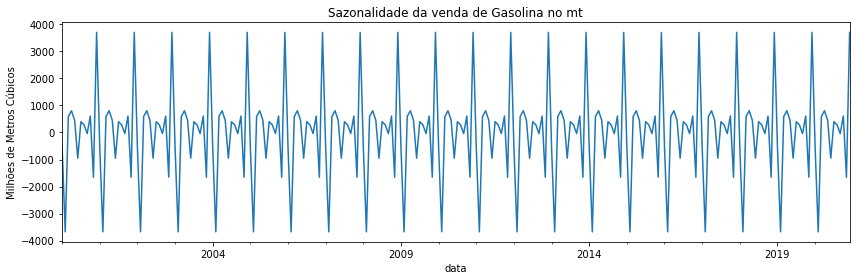

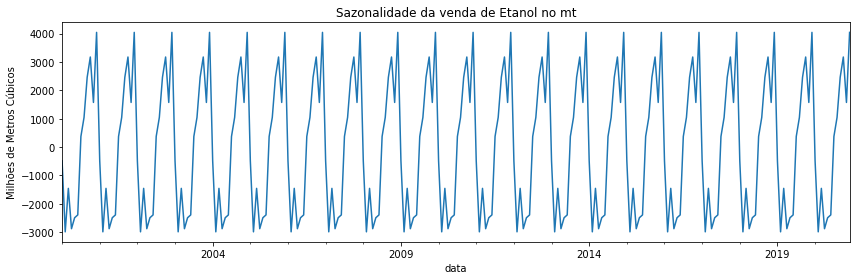

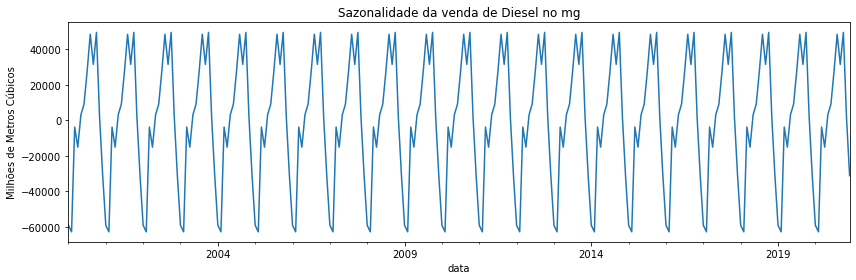

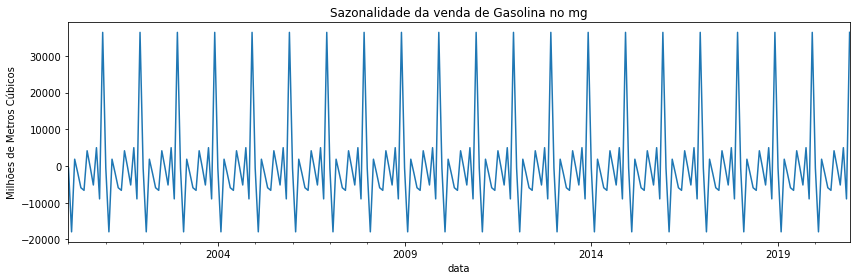

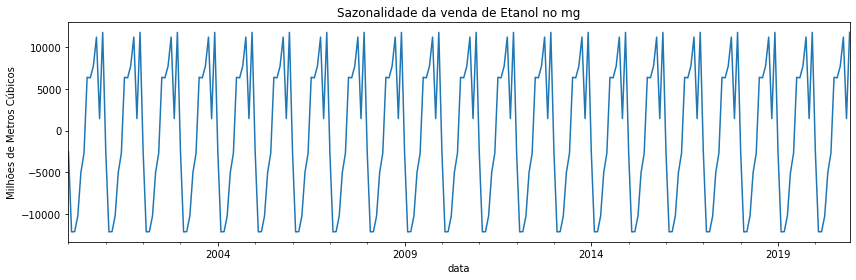

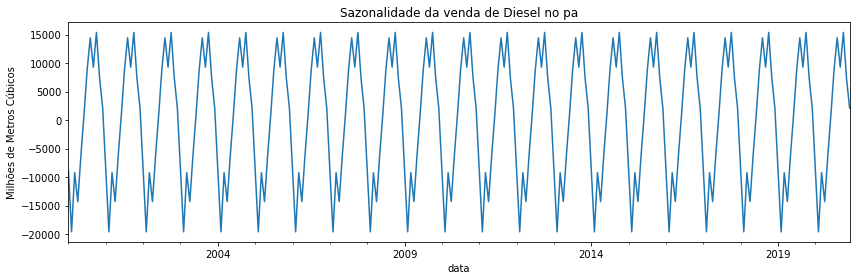

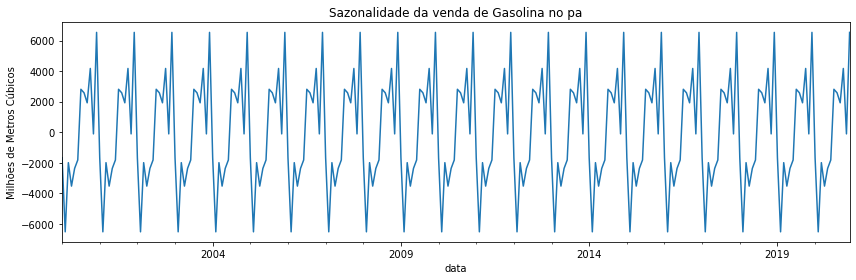

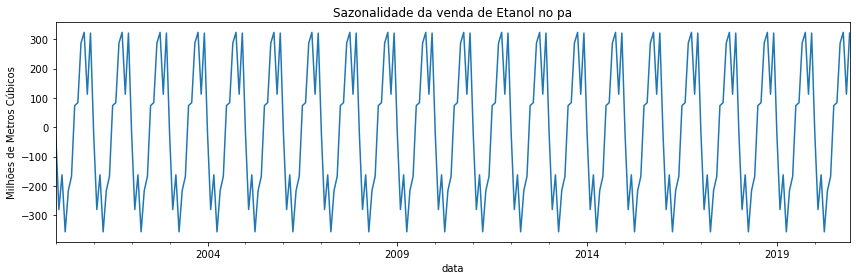

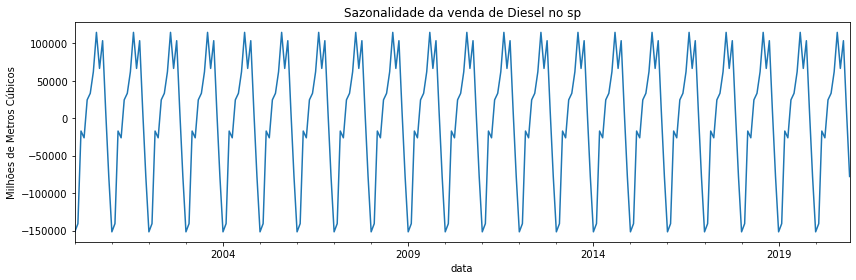

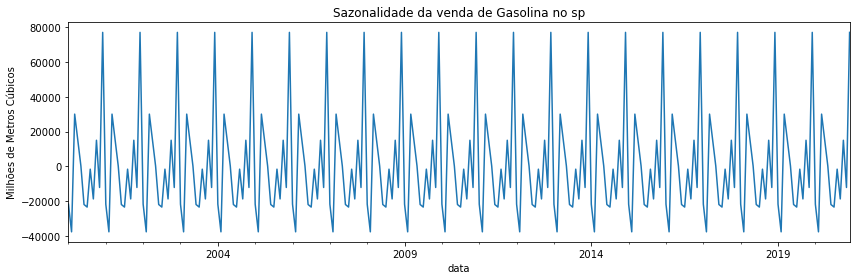

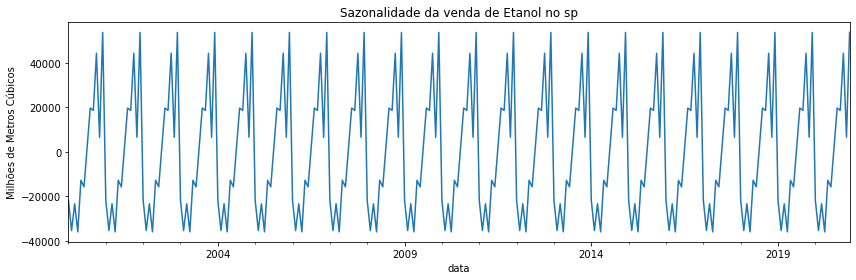

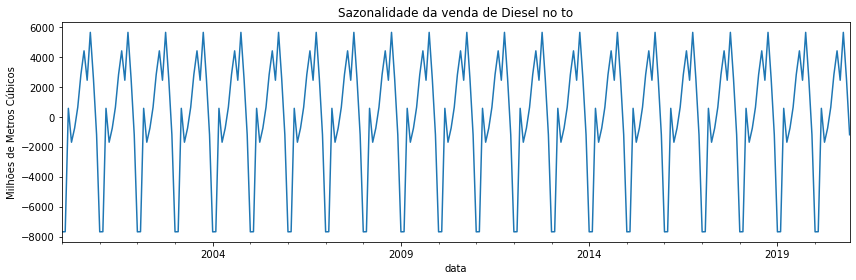

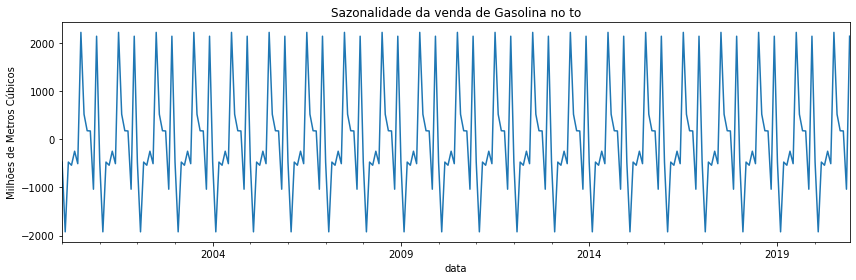

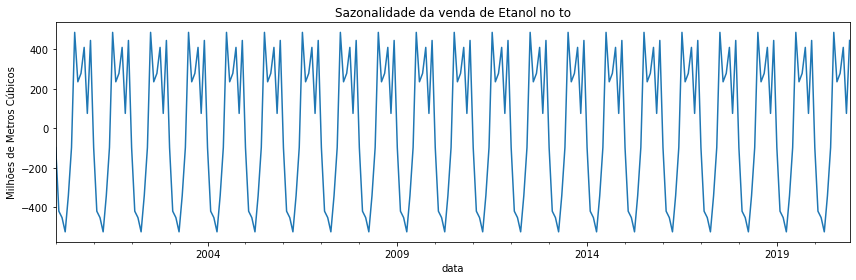

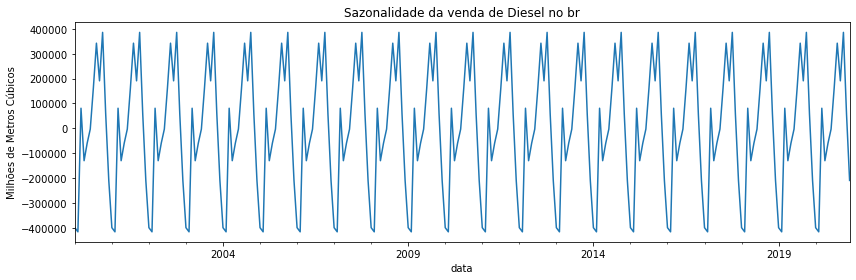

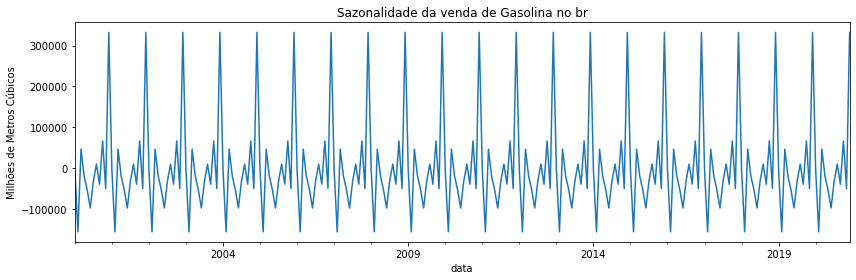

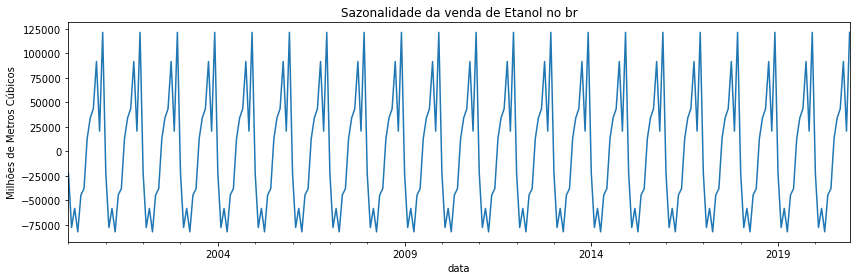

In [41]:
#loop para criar gráficos de sazonalidade do consumo dos 3 combustíveis para todos os estados

for ite in anp_diesel["regiao"].unique():
    analisecombsazon_d = sazonalidade_vendas(anp_diesel,"Diesel",ite)
    analisecombsazon_g = sazonalidade_vendas(anp_gasolina,"Gasolina",ite)
    analisecombsazon_e = sazonalidade_vendas(anp_etanol,"Etanol",ite)

Agora sim é possível inferir que existe sazonalidade na venda de todos os 3 tipos de combustíveeis para todos os estados disponíveis.

E, apesar das sazonalidades nas vendas de um mesmo tipo de combustível para os estados assemelharem-se, eles não são iguais. Importante destacar também que combustíveis diferentes possuem sazonalidades diferentes.

Como o consumo de cada tipo de combustível está distribuído entre os estados brasileiros?

In [42]:
#função que transforma a base em série temporal, ela diferencia da sazonalidade_vendas() pois não extrai o componente sazonal das séries, apenas transforma em série temporal

def sazonalidades(df_comb,nome_comb,regiao):
    df_comb=df_comb[df_comb['regiao']==regiao]
    df_comb = df_comb.drop(['regiao'], axis=1)
    df2 = df_comb.set_index('meses').stack().to_frame(name=f'vendas_comb_{regiao}')
    df2 = df2.reset_index().rename(columns={'level_1': 'ano'})
    df2['ano'] = df2['ano'].astype(str)
    df2['data'] = df2.apply(cnv, axis=1)
    df2 = df2.drop(['ano', 'meses'], axis=1).sort_index(axis=1)
    df2 = df2.sort_values(by='data')
    return df2

In [43]:
#função que faz uma analise regional em % da participação na venda dos combustíveis

def analise_regional(df_comb,nome_comb):
    lista_df = []
    for ite in df_comb["regiao"].unique():
        analisecombsazon_c = sazonalidades(df_comb,nome_comb,ite)
        lista_df.append(analisecombsazon_c)
    comb_merged = reduce(lambda  left,right: pd.merge(left,right,on='data',
                                                how='outer'), lista_df) #dataframe para calculo de participação
    comb_pct = pd.DataFrame()
    for cols in comb_merged.iloc[:,1:]:
        comb_pct[cols] = (comb_merged[cols]/comb_merged['vendas_comb_br'])*100 #calculando participação dos estados
    comb_br, ax = plt.subplots(figsize=(12,4))
    for i in range(0,8):
        ax.plot(comb_merged["data"],comb_pct.iloc[:,i],label=comb_pct.columns[i]) 
        ax.set_xlabel("Meses")
        ax.set_ylabel(f"% da Venda de {nome_comb}")
        ax.set_title(f"Venda de {nome_comb} por estado no BR")
        comb_br.legend()
    return comb_br

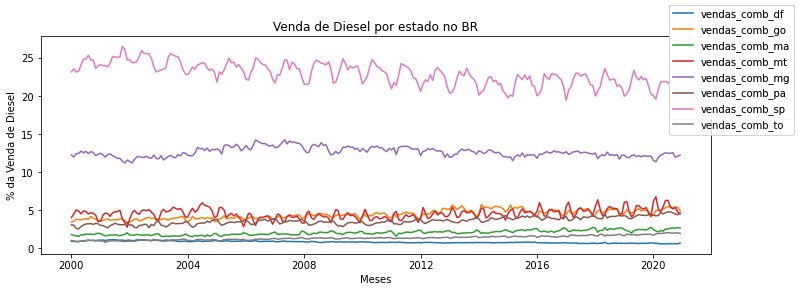

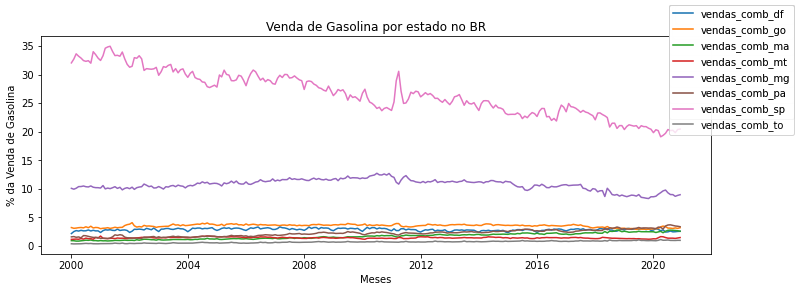

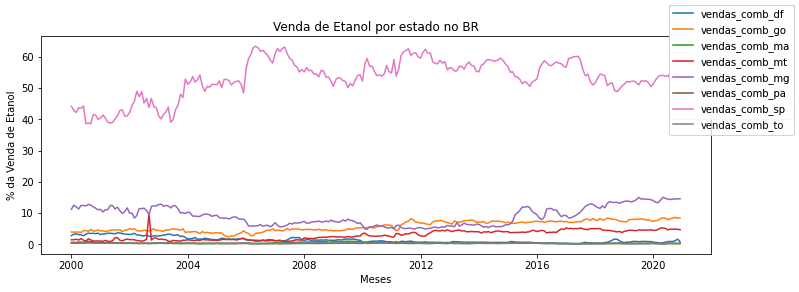

In [44]:
#analise regional para os 3 tipos de combustíveis

analise_diesel = analise_regional(anp_diesel, 'Diesel')
analise_gasolina = analise_regional(anp_gasolina, 'Gasolina')
analise_etanol = analise_regional(anp_etanol, 'Etanol')

É notavel que SP concentra a maior parte dos consumos dos 3 tipos de combustíveis. Sendo essa distribuição menos concetrada quando se refere a Gasolina e Diesel e bem mais concentrada quando se refere a Etanol.